This notebook is going to explore linear sum assignment. This is a problem that comes up in many different contexts.  For example, you might want to assign workers to tasks, or you might want to assign students to projects.  In this notebook, we'll look at a few different ways to solve this problem.

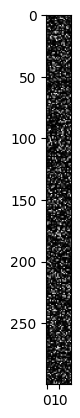

In [6]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import torch 
import matplotlib.pyplot as plt
TestTensor=torch.rand((300,20))

plt.imshow(TestTensor.pow(5),cmap='gray')
plt.show()

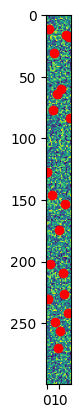

In [7]:
TruthIndices=linear_sum_assignment(TestTensor.numpy(), maximize=True)

plt.imshow(TestTensor)
plt.scatter(TruthIndices[1],TruthIndices[0],c='r')
plt.show()

scipy took: 0.00019931793212890625
MyLinearSumAssignment took: 0.0034418106079101562
0.0


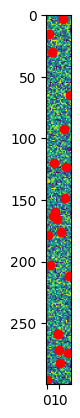

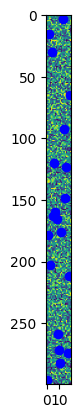

tensor(19.9182, device='cuda:0')
tensor(19.9182, device='cuda:0')
{(259, 9), (3, 13), (163, 5), (165, 8), (15, 2), (296, 0), (120, 6), (92, 14), (148, 15), (212, 18), (178, 1), (203, 3), (123, 16), (274, 17), (30, 4), (160, 7), (176, 12), (65, 19), (282, 11), (272, 10)}
{(259, 9), (3, 13), (163, 5), (165, 8), (15, 2), (296, 0), (120, 6), (92, 14), (148, 15), (212, 18), (178, 1), (203, 3), (123, 16), (274, 17), (30, 4), (160, 7), (176, 12), (65, 19), (282, 11), (272, 10)}


In [8]:
def LinearSumAssignmentLoss(TruthIndices, PredictedIndices):
    return torch.sum(torch.pow(TruthIndices-PredictedIndices,2))


###
'''
Linear sum assignment stages:
Step 1: Sort the tensor by the columns, max value at the top
#Step 2 (Optional) crop max values down to a square
Step 3: take top 2 rows and find the biggest delta in the vertical direction and select that Value
step 4: mark out everything on that row and column as not selectable 
'''


@torch.jit.script_if_tracing
def MyLinearSumAssignment(TruthTensor, maximize=True,lookahead=2):
    '''
    If Maximize is False, I'm trying to minimize the costs. 
    This means that the mask must instead make all the weights far above all the others - 'inf' kind of thing. 
    '''
    #assert truthtensor is 2d and nonzero
    assert len(TruthTensor.shape)==2
    assert TruthTensor.shape[0]>0 and TruthTensor.shape[1]>0
    assert lookahead>0
    assert torch.sum(TruthTensor==0)==0

    mask=torch.ones(TruthTensor.shape,device=TruthTensor.device)
    results=torch.zeros(TruthTensor.shape,device=TruthTensor.device)

    finder=torch.argmax if maximize else torch.argmin
    replaceval=0 if maximize else float(1e9)

    for i in range(min(TruthTensor.shape[-2:])): # number of rows
        deltas=torch.diff(torch.topk(torch.clamp(TruthTensor*mask,max=100),lookahead,dim=0,largest=maximize).values,n=lookahead-1,dim=0)
        col_index=torch.argmax(torch.abs(deltas)) # this is the column to grab,  Note this measures step so its not important to do argmin...
        row_index=finder(TruthTensor[:,col_index])
        mask[:,col_index]=replaceval #mask out the column
        mask[row_index]=replaceval
        results[row_index,col_index]=1
    return results.nonzero(as_tuple=True) 
TestTensor=torch.rand((300,20))
TestTensor=TestTensor.to("cuda")
#time this 
import time 



start=time.time()

X,Y= linear_sum_assignment(TestTensor.cpu().numpy(), maximize=True)
X=torch.from_numpy(X).to("cuda")
Y=torch.from_numpy(Y).to("cuda")
end=time.time()-start
print("scipy took:",end)

start = time.time()
x,y= MyLinearSumAssignment(TestTensor,maximize=True)
end = time.time()-start




print("MyLinearSumAssignment took:",end)




#do intersection over union
print(len(set(zip(x,y)).intersection(set(zip(X,Y))))/len(set(zip(x,y)).union(set(zip(X,Y)))))
#sum of scores at those indices

plt.imshow(TestTensor.cpu().numpy())
plt.scatter(y.cpu().numpy(),x.cpu().numpy(),c='r')
plt.show()

plt.imshow(TestTensor.cpu().numpy())
plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),c='b')
plt.show()

print(TestTensor[x,y].sum())

print(TestTensor[X,Y].sum())


x,y=x.tolist(),y.tolist()
X,Y=X.tolist(),Y.tolist()
print(set(zip(x,y)))
print(set(zip(X,Y)))


In [9]:
for i in range(10):
    MyLinearSumAssignment(torch.rand((20,80)))

Batched runtimes. The linear sum assignment in use actually runs cpu bound as

batched_indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(tgt_sizes.tolist(), -1))]

It's actually quite useful to see if theres a way to parallelize this. I'm not sure if there is, but it's worth looking into.


In [206]:
from scipy.optimize import linear_sum_assignment
import torch
import matplotlib.pyplot as plt

import time
def original_method(C: torch.Tensor,sizes: torch.Tensor):
    return [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes.tolist(), -1))]

##I want to know if theres optimizations in this if I rewrite it to do this at each step
@torch.no_grad()
def lookup_sizes(sizes:torch.Tensor):
    mask=torch.zeros((sizes.sum(),sizes.sum()),device=sizes.device)
    start=0
    for i in range(len(sizes)):
        mask[start:start+sizes[i],start:start+sizes[i]]=1
        start+=sizes[i]
    plt.imshow(mask)
    return mask.bool()

@torch.no_grad()
def lookup_sizes_vfast(sizes:torch.Tensor):
    return torch.diag(torch.ones_like(sizes)).repeat_interleave(sizes,dim=0).repeat_interleave(sizes,dim=1).to(dtype=torch.long,device=sizes.device)

@torch.no_grad()
#@torch.jit.script
def Batch_MyLinearSumAssignment(Batched_TruthTensor:torch.Tensor,row_lookups:torch.Tensor, maximize=False,lookahead=2):
    mask=torch.ones(Batched_TruthTensor.shape,device=Batched_TruthTensor.device)
    results=torch.zeros(Batched_TruthTensor.shape,device=Batched_TruthTensor.device)
    finder,replaceval=(torch.argmax,0) if maximize else (torch.argmin,float(1e9))
    for _ in range(row_lookups.shape[0]): # number of columns
        deltas=torch.diff(torch.topk(torch.clamp(Batched_TruthTensor*mask,max=100),lookahead,dim=0,largest=maximize).values,n=lookahead-1,dim=0)
        col_index=torch.argmax(torch.abs(deltas[0])) 
        row_index=finder(Batched_TruthTensor[:,col_index],dim=0) # BxB
        mask[:,col_index]=replaceval 
        mask[row_index,row_lookups[col_index]]=replaceval
        results[row_index,col_index]=1
    return results
@torch.no_grad()
#@torch.jit.script
def in_place_Batch_MyLinearSumAssignment(Batched_TruthTensor:torch.Tensor,row_lookups:torch.Tensor, maximize=False,lookahead=2):
    #results=torch.zeros(Batched_TruthTensor.shape,device=Batched_TruthTensor.device)
    finder,replaceval=(torch.argmax,torch.tensor(0)) if maximize else (torch.argmin,torch.tensor(1e9))
    r=torch.tensor([],dtype=torch.long,device=Batched_TruthTensor.device)
    c=torch.tensor([],dtype=torch.long,device=Batched_TruthTensor.device)

    for i_ in range(Batched_TruthTensor.shape[0]): # number of columns
        col_index=torch.argmax(torch.abs(torch.diff(torch.topk(torch.clamp(Batched_TruthTensor*calculate_mask(Batched_TruthTensor,r,c,row_lookups,replaceval=replaceval),max=100),lookahead,dim=0,largest=maximize).values,n=lookahead-1,dim=0)[0]))
        c=torch.cat([c,col_index.unsqueeze(0)])
        r=torch.cat([r,finder(Batched_TruthTensor[:,col_index],dim=0).unsqueeze(0)])
    return r,c

def no_for_loop_Batch_MyLinearSumAssignment(Batched_TruthTensor:torch.Tensor,row_lookups:torch.Tensor, maximize=False,lookahead=2):
    #We're going to first make our cube, which will be BxBxB
    #We're going to do this by making a BxB matrix, and then repeating it B times
    #results=torch.zeros(Batched_TruthTensor.shape,device=Batched_TruthTensor.device).unsqueeze(-1).repeat(1,1,Batched_TruthTensor.shape[-1])
    #our first the first set of deltas will be the topk of the first BxB matrix
    #finder=(torch.argmax,torch.argmin)[maximize]


    #for n in nth slice of cube, I want to find the biggest gap between the max and nth highest value in the column 
    topk_values,topk_ind=torch.topk(torch.clamp(Batched_TruthTensor.unsqueeze(-1).repeat(1,1,Batched_TruthTensor.shape[-1]),max=100),k=Batched_TruthTensor.shape[-1],dim=0,largest=maximize)
    #shape is BxBxB
    #for each slice of the cube, I want to find the biggest gap between the max and nth highest value in the column so the shape is BxB
    #print("values",topk_values.shape)
    #fulldeltas=torch.stack([
    #                    torch.diff(topk_values[:,:,n],n=n,dim=0)[0]
    #                    for n in range(Batched_TruthTensor.shape[-1])],dim=0)
    #print("fulldeltas",fulldeltas.shape) # these are the deltas for each column, from the maximum value to the nth highest value going down the column
    #shape is BxB    
    deltas=torch.diff(topk_values,n=1,dim=0)
    
    selection=deltas.diagonal(dim1=1,dim2=2) # this is the difference between the nth highest value and the n+1th highest value in the column

    col_index=torch.argmax(torch.abs(selection),dim=0,keepdim=False)
    #This should find the column with the biggest gap in the cube and be in the form _,_,B
    row_index=topk_ind.diagonal(dim1=1,dim2=2)[:,col_index] # BxB
    
    #This should find the rows with the biggest gap in the cube and be in the form _,_,B
    #print(col_index)
    #print(row_index)
    #I had expected to end in a one_hot matrix, but I think I'm going to end in a list of indices, and doing a .sum(-1) 
    return col_index,row_index

def calculate_mask(shape:torch.Tensor,ros,cols,row_lookups,replaceval:torch.Tensor=torch.tensor(0)):
    tensor=torch.ones_like(shape,dtype=torch.float)
    tensor[ros]=torch.where(row_lookups[cols]>0,replaceval,row_lookups[cols])
    tensor[:,cols]=replaceval
    return tensor




Batched_TestTensor=torch.rand((8,300,30))
sizes=torch.tensor([5,4,3,4,5,4,5],device=Batched_TestTensor.device)
start=time.time()
outputs=original_method(Batched_TestTensor.clone().cpu(),sizes)
end=time.time()-start
print("original method took:",end)
print(outputs)
fx=torch.cat([c[i] for i,c in enumerate(Batched_TestTensor.split(sizes.tolist(), -1))],dim=1)
row_lookups=lookup_sizes_vfast(sizes)
start=time.time()

outputs=Batch_MyLinearSumAssignment(fx,row_lookups=row_lookups)
#if I want comparable format I can do [r.nonzero(as_tuple=True) for r in results.split(Sizes.tolist(),-1)]
end=time.time()-start
print("Batch_MyLinearSumAssignment took:",end)
#inplace=torch.compile(in_place_Batch_MyLinearSumAssignment) 

start=time.time()
outputs=in_place_Batch_MyLinearSumAssignment(fx,row_lookups=row_lookups)
#if I want comparable format I can do [r.nonzero(as_tuple=True) for r in results.split(Sizes.tolist(),-1)]
end=time.time()-start
print(" in_Batch_MyLinearSumAssignment took:",end)

start=time.time()
outputs=no_for_loop_Batch_MyLinearSumAssignment(fx,row_lookups=row_lookups)
#if I want comparable format I can do [r.nonzero(as_tuple=True) for r in results.split(Sizes.tolist(),-1)]
end=time.time()-start
print(" no_for_loop_Batch_MyLinearSumAssignment took:",end)
#print(outputs)


original method took: 0.00046896934509277344
[(array([ 92,  95, 154, 179, 299]), array([1, 0, 2, 4, 3])), (array([ 78,  91, 248, 289]), array([1, 3, 0, 2])), (array([  3,  95, 259]), array([1, 2, 0])), (array([  9,  54, 154, 269]), array([1, 2, 0, 3])), (array([ 80,  82, 114, 220, 222]), array([4, 3, 0, 1, 2])), (array([13, 81, 90, 96]), array([0, 3, 2, 1])), (array([ 89, 189, 245, 272, 276]), array([4, 1, 2, 3, 0]))]
Batch_MyLinearSumAssignment took: 0.004376888275146484
 in_Batch_MyLinearSumAssignment took: 0.0659339427947998
 no_for_loop_Batch_MyLinearSumAssignment took: 0.0003695487976074219


In [ ]:
import torch
from functools import reduce,partial
import matplotlib.pyplot as plt
import numpy as np
# Defining the user-defined cubes() function
def square(logits):
    #a function that takes numpy logits and plots them on an x and y axis
    logits=torch.clamp(logits,min=-1,max=1)

    plt.figure(figsize=(logits.shape[0],logits.shape[1]))
    plt.imshow(logits)
    plt.show()



def cubes(logits):
    # Defining the size of the axes
    logits=torch.clamp(logits,min=-1,max=1)
    x, y, z = np.indices(logits.shape)
    sidex,sidey,sidez=logits.shape
    # Defining the length of the sides of the cubes
    cube = (x < sidex) & (y < sidey) & (z < sidez)
    # Defining the shape of the figure to be a cube
    voxelarray = cube
    # Defining the colors for the cubes
    colors = np.empty((3,*voxelarray.shape), dtype=float)
    # Defining the color of the cube
    c=np.sqrt(np.sqrt(logits.flatten()).unflatten(0,(sidex,sidey,sidez)).cpu().numpy())
    #colors[cube] = c.astype(str)[cube]
    colors= np.stack([c,c, c],axis=-1) #c,c,1-c
    #print(colors.shape)
    # Defining the axes and the figure object
    ax = plt.figure(figsize=(9, 9)).add_subplot(projection='3d')
    # Plotting the cube in the figure
    ax.voxels(voxelarray , facecolors=colors, edgecolor='k')
    # Defining the title of the graph
    #plt.title("Batch MSE loss between random values and perfect case in n=3 dimensions")
    # Displaying the graph
    plt.show()

def hsquare(logits):
    # Defining the size of the axes
    logits=torch.clamp(logits,min=-1,max=1)

    sidew,sidex,sidey,sidez=logits.shape
    x,y = np.indices((sidew*sidex,sidey*sidez))
    # Defining the length of the sides of the cubes
    square = (x < (sidew*sidex)) & (y < (sidey*sidez))
    # Defining the shape of the figure to be a cube
    voxelarray = square
    # Defining the colors for the cubes
    colors = np.empty((*voxelarray.shape,3), dtype=int)
    # Defining the color of the cube
    #input is shape (B, B, B,B)
    #C needs to be (b*b, B*b) \
    c=torch.softmax(logits.flatten(),dim=0).unflatten(0,(sidew*sidex,sidey*sidez)).cpu().numpy()
    c=c/np.amax(c)

    #c=np.sqrt(np.sqrt(smax(MLoss(sqsqlogits,pfsqsqlogits).flatten()).unflatten(0,(B*B,B*B)).cpu().numpy()))
    colors= np.stack([c,c,c],axis=-1)
    # Defining the axes and the figure object
    ax = plt.imshow(colors[:, :, :])

    # Plotting the cube in the figure
    # Defining the title of the graph
    #plt.title("Perfect case logits in n=4 dimensions plotted on a (B^2, B^2) ")
    # Displaying the graph
    plt.show()
# Defining the main() function
def hypcubes(side):
    # Defining the size of the axes
    u,v,w,x, y, z = np.indices((B,B,B,B, B, B))
    # Defining the length of the sides of the cubes
    cube =  (u < side) & (v < side) & (w < side)& (x < side) & (y < side) & (z < side)
    # Defining the shape of the figure to be a cube
    voxelarray = cube
    # Defining the colors for the cubes
    colors = np.empty(voxelarray.shape, dtype=object)
    # Defining the color of the cube
    c=np.sqrt(np.sqrt(torch.softmax(Blogits.flatten()).unflatten(0,(B,B,B,B,B,B)).cpu().numpy()))*2
    colors[cube] = c.astype(str)[cube]
    # Defining the axes and the figure object
    ax = plt.figure(figsize=(9, 9)).add_subplot(projection='3d')
    # Plotting the cube in the figure
    ax.voxels(voxelarray , facecolors=colors, edgecolor='k')
    # Defining the title of the graph
    #plt.title("Batch MSE loss between random values and perfect case in n=3 dimensions")
    # Displaying the graph
    plt.show()
def draw(logits):
    # Defining the side of the cube
    sides = len(logits.shape) #(subtract to take slices)
    # Calling the cubes () function
    #cubes(sides)
    if sides==2:
      square(logits)
    if sides==3:
      cubes(logits)
    if sides==4:
      hsquare(logits)
    if sides==6:
      hypcubes(logits)


In [192]:
import torch
from matplotlib import pyplot as plt

def no_for_loop_triu_MyLinearSumAssignment(rewards:torch.Tensor,maximize=False):
    cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(0,torch.max,torch.sub,torch.argmax))[maximize]
    remove=torch.ones_like(rewards,dtype=torch.bool).triu().unsqueeze(0).repeat(*tuple([rewards.shape[-1]]+[1]*len(rewards.shape)))
    weights=rewards.unsqueeze(-1).repeat(*tuple([1]*len(rewards.shape)+[rewards.shape[-1]]))
    weights=weights.masked_fill(remove,cost_neg)#.permute(1,2,0)
    Costs=next_highest_fn(weights,dim=0).values
    Locations=comb_fn(rewards,Costs)
    col_index=final_fn(Locations,dim=1)
    return torch.arange(Locations.shape[0],device=Locations.device),col_index

def no_for_loop_MyLinearSumAssignment(rewards:torch.Tensor,maximize=False,tril=False):

    cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(0,torch.max,torch.sub,torch.argmax))[maximize]
    remove=torch.zeros_like(rewards,dtype=torch.bool).fill_diagonal_(1).unsqueeze(0).repeat(*tuple([rewards.shape[-1]]+[1]*len(rewards.shape)))
    weights=rewards.unsqueeze(-1).repeat(*tuple([1]*len(rewards.shape)+[rewards.shape[-1]]))
    weights=weights.masked_fill(remove,cost_neg)#.permute(1,2,0)
    Costs=next_highest_fn(weights,dim=0).values
    #plt.show(plt.imshow(Costs.cpu().numpy()))
    
    Locations=comb_fn(rewards,Costs)
    col_index=final_fn(Locations,dim=1)

    return torch.arange(Locations.shape[0],device=Locations.device),col_index
def no_for_loop_v2_MyLinearSumAssignment(rewards:torch.Tensor,maximize=False,tril=False):
    cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(0,torch.max,torch.sub,torch.argmax))[maximize] 
    remove=torch.zeros_like(rewards,dtype=torch.bool).fill_diagonal_(1).unsqueeze(0).repeat(*tuple([rewards.shape[-1]]+[1]*len(rewards.shape)))
    weights=rewards.unsqueeze(-1).repeat(*tuple([1]*len(rewards.shape)+[rewards.shape[-1]]))
    weights1=weights.masked_fill(remove,cost_neg)#.permute(1,2,0)
    weights2=weights.masked_fill(remove.permute(1,0,2),cost_neg)#.permute(1,2,0)

    Costs=next_highest_fn(weights1,dim=1).values
    Costs2=next_highest_fn(weights2,dim=0).values

    Cost_total=Costs+Costs2
    Locations=rewards - Cost_total/2
    col_index=final_fn(Locations,dim=1)

    return torch.arange(Locations.shape[0],device=Locations.device),col_index

def no_for_loop_v2_triu_MyLinearSumAssignment(rewards:torch.Tensor,maximize=False,tril=False):

    cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(0,torch.max,torch.sub,torch.argmax))[maximize]
   
    remove=torch.ones_like(rewards,dtype=torch.bool).tril().unsqueeze(0).repeat(*tuple([rewards.shape[-1]]+[1]*len(rewards.shape)))
    weights=rewards.unsqueeze(-1).repeat(*tuple([1]*len(rewards.shape)+[rewards.shape[-1]]))
    weights1=weights.masked_fill(remove,cost_neg)#.permute(1,2,0)
    weights2=weights.masked_fill(remove.permute(1,0,2),cost_neg)#.permute(1,2,0)
    Costs=next_highest_fn(weights1,dim=1).values 
    Costs2=next_highest_fn(weights2,dim=0).values
    Cost_total=Costs+Costs2
    Locations=rewards - Cost_total/2
    col_index=final_fn(Locations,dim=1)
    return torch.arange(Locations.shape[0],device=Locations.device),col_index
def no_for_loop_v3_MyLinearSumAssignment(rewards:torch.Tensor,maximize=False,tril=False):
    cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(0,torch.max,torch.sub,torch.argmax))[maximize] 
    remove=torch.zeros_like(rewards,dtype=torch.bool).fill_diagonal_(1).unsqueeze(0).repeat(*tuple([rewards.shape[-1]]+[1]*len(rewards.shape)))
    weights=rewards.unsqueeze(-1).repeat(*tuple([1]*len(rewards.shape)+[rewards.shape[-1]]))
    weights1=weights.masked_fill(remove,cost_neg)#.permute(1,2,0)
    weights2=weights.masked_fill(remove.permute(1,0,2),cost_neg)#.permute(1,2,0)

    Costs=next_highest_fn(weights1,dim=1).values
    Costs2=next_highest_fn(weights2,dim=0).values

    Cost_total=Costs+Costs2
    Locations=rewards - Cost_total/2
    col_index=final_fn(Locations,dim=1)

    return torch.arange(Locations.shape[0],device=Locations.device),col_index

def no_for_loop_v3_triu_MyLinearSumAssignment(rewards:torch.Tensor,maximize=False,tril=False):

    cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(0,torch.max,torch.sub,torch.argmax))[maximize]
   
    remove=torch.ones_like(rewards,dtype=torch.bool).tril().unsqueeze(0).repeat(*tuple([rewards.shape[-1]]+[1]*len(rewards.shape)))
    weights=rewards.unsqueeze(-1).repeat(*tuple([1]*len(rewards.shape)+[rewards.shape[-1]]))
    weights1=weights.masked_fill(remove,cost_neg)#.permute(1,2,0)
    weights2=weights.masked_fill(remove.permute(1,0,2),cost_neg)#.permute(1,2,0)
    Costs=next_highest_fn(weights1,dim=1).values 
    Costs2=next_highest_fn(weights2,dim=0).values
    Cost_total=Costs+Costs2
    Locations=rewards - Cost_total/2
    col_index=final_fn(Locations,dim=1)
    return torch.arange(Locations.shape[0],device=Locations.device),col_index

def reduceLinearSumAssignment(rewards:torch.Tensor,cost_neg,next_highest_fn,remove):
    weights=rewards.unsqueeze(-1).repeat(*tuple([1]*len(rewards.shape)+[rewards.shape[-1]]))
    weights1=weights.masked_fill(remove,cost_neg)#.permute(1,2,0)
    weights2=weights.masked_fill(remove.permute(1,0,2),cost_neg)#.permute(1,2,0)
    
    Costs=next_highest_fn(weights1,dim=1).values #should not be 0  
    Costs2=next_highest_fn(weights2,dim=0).values #should not be 0
    Cost_total=Costs+Costs2.T
    
    return Cost_total

def recursiveLinearSumAssignment(rewards:torch.Tensor,maximize=False,factor=1.3):
    cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(-1e9,torch.max,torch.sub,torch.argmax))[maximize] 
    #cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(-1e9,torch.max,torch.sub,torch.argmax))[maximize] 
    remove=torch.zeros_like(rewards,dtype=torch.bool).fill_diagonal_(1).unsqueeze(0).repeat(*tuple([rewards.shape[-1]]+[1]*len(rewards.shape)))
    y_values=[]
    for i in range(rewards.shape[-1]):
        cost=reduceLinearSumAssignment(rewards,cost_neg,next_highest_fn,remove)
        rewards=rewards - cost/factor
        col_index=final_fn(rewards,dim=1)
        x,y=torch.arange(rewards.shape[0],device=rewards.device),col_index
        y_values.append(y)
    
    return torch.arange(rewards.shape[0],device=rewards.device),col_index, y_values

def recursiveLinearSumAssignment_v2(rewards:torch.Tensor,maximize=False,factor=0.1):
    cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(-1e9,torch.max,torch.sub,torch.argmax))[maximize] 
    #cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(-1e9,torch.max,torch.sub,torch.argmax))[maximize] 
    remove=torch.zeros_like(rewards,dtype=torch.bool).fill_diagonal_(1).unsqueeze(0).repeat(*tuple([rewards.shape[-1]]+[1]*len(rewards.shape)))
    y_values=[]
    for i in range(rewards.shape[-1]):
        cost=reduceLinearSumAssignment(rewards,cost_neg,next_highest_fn,remove)
        rewards=rewards/ (cost/factor)
        col_index=final_fn(rewards,dim=1)
        x,y=torch.arange(rewards.shape[0],device=rewards.device),col_index
        y_values.append(y)
    
    return torch.arange(rewards.shape[0],device=rewards.device),col_index, y_values

from scipy.optimize import linear_sum_assignment
#try linear sum assignment
import time

Batched_TestTensor=torch.abs(torch.rand((8,30,30))).cuda()

start=time.time()
X,Y=linear_sum_assignment(Batched_TestTensor[0].cpu().numpy(), maximize=True)
end=time.time()-start
print("scipy took:",end)
print("score:",Batched_TestTensor[0][X,Y].sum())
x,y,_=recursiveLinearSumAssignment(Batched_TestTensor[0],maximize=True)
end=time.time()-start
print("func {} \n TOOK {}, \n ACC : {}/{}".format("recursive",end,torch.sum(y.cpu()==torch.as_tensor(Y)),len(Y)))
print("score:",Batched_TestTensor[0][x,y].sum())
x1,y1,_=recursiveLinearSumAssignment_v2(Batched_TestTensor[0],maximize=True)
end=time.time()-start
print("func {} \n TOOK {}, \n ACC : {}/{}".format("recursive v2",end,torch.sum(y1.cpu()==torch.as_tensor(Y)),len(Y)))
print("score:",Batched_TestTensor[0][x1,y1].sum())
for factor in np.arange(0.2,3,0.1):
    y_values=torch.zeros((30,30))

    for i in range(5000):
        Batched_TestTensor=torch.abs(torch.rand((30,30)))
        X,Y=linear_sum_assignment(Batched_TestTensor.cpu().numpy(), maximize=True)
        x,y,y_val=recursiveLinearSumAssignment(Batched_TestTensor,maximize=True,factor=factor)
        y_values=y_values+ (torch.stack(y_val,dim=0).cpu()==torch.as_tensor(Y)).int()
    title="A Graph showing mean accuracy based on averaging factor:{}".format(factor)
    plt.title(title)
    #x axis is the number of times the algorithm was run
    #y axis is the accuracy
    x_axis="Number of times the steps"
    y_axis="Fraction of correct assignments"
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)

    plt.plot(torch.mean(y_values,dim=1)/5000,label="factor:{}".format(factor))
    
plt.show()
for factor in np.arange(0.2,3,0.1):
    y_values=torch.zeros((30,30))

    for i in range(5000):
        Batched_TestTensor=torch.abs(torch.rand((30,30)))
        X,Y=linear_sum_assignment(Batched_TestTensor.cpu().numpy(), maximize=True)
        x,y,y_val=recursiveLinearSumAssignment_v2(Batched_TestTensor,maximize=True,factor=factor)
        y_values=y_values+ (torch.stack(y_val,dim=0).cpu()==torch.as_tensor(Y)).int()
    title="A Graph showing mean accuracy based on multiplying by costs, factor:{}".format("0.2 - 3 in steps of 0.1")
    plt.title(title)
    #x axis is the number of times the algorithm was run
    #y axis is the accuracy
    x_axis="Number of times the steps"
    y_axis="Fraction of correct assignments"
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)

    plt.plot(torch.mean(y_values,dim=1)/5000,label="factor:{}".format(factor))
    
plt.show()





scipy took: 0.00013637542724609375
score: tensor(28.3415, device='cuda:0')
func recursive 
 TOOK 0.004324197769165039, 
 ACC : 22/30
score: tensor(27.7009, device='cuda:0')
func recursive v2 
 TOOK 0.009578466415405273, 
 ACC : 23/30
score: tensor(27.6123, device='cuda:0')



from scipy.optimize import linear_sum_assignment
#try linear sum assignment
import time
start=time.time()
X,Y=linear_sum_assignment(Batched_TestTensor[0].cpu().numpy(), maximize=False)
end=time.time()-start
print("scipy took:",end)
print("score:",Batched_TestTensor[0][X,Y].sum())
trial_functions=[no_for_loop_MyLinearSumAssignment,
                 no_for_loop_triu_MyLinearSumAssignment,
                 no_for_loop_v2_MyLinearSumAssignment,
                 no_for_loop_v2_triu_MyLinearSumAssignment,
                 no_for_loop_v3_MyLinearSumAssignment,
                 no_for_loop_v3_triu_MyLinearSumAssignment]
for func in trial_functions:
    warmup,_=func(Batched_TestTensor[0])
    start=time.time()
    x,y=func(Batched_TestTensor[0],maximize=False)
    end=time.time()-start
    print("func {} \n TOOK {}, \n ACC : {}/{}".format(func,end,torch.sum(y==torch.as_tensor(Y)),len(Y)))
    print("score:",Batched_TestTensor[0][x,y].sum())